###Wednesday MeetUp 052 - Beginners Python and Machine Learning - 24th Mar 2020 - Optimise Tesla SA Battery
Continuation from MeetUp 048 on 25th Feb 2020

Learning objectives:
- Object oriented program (class)
- pandas DataFrames
- scipy optimize

@author D Tim Cummings

Project to optimise operation of a South Australian style Tesla battery linked to a solar farm


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
import random
import logging

In [0]:
%matplotlib inline

In [0]:
# pandas and matplotlib are producing some warnings which we don't need to see
import matplotlib
import warnings
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [0]:
def plot_by_hour(df_for_plot, title):
  ax = plt.gca()  # get current axis so that both plots are on same chart
  plt.xlabel('hour of day')
  plt.suptitle('Profile')
  plt.title(title)
  df_for_plot.plot(kind='line', y='SCADAVALUE', ax=ax, color='yellow')
  plt.ylabel('Average MW generation during hour')
  df_for_plot.plot(kind='line', y='RRP', ax=ax, secondary_y=True, color='red')
  ax.set_ylim([0, df_for_plot['SCADAVALUE'].max() * 1.1])
  ax.right_ax.set_ylim([0, df_for_plot['RRP'].max() * 1.1])
  ax.legend(loc='best')
  plt.ylabel('Average $/MWh during hour')
  plt.show()


def plot_battery(df_for_plot):
  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), sharex='all')
  axes[0].set_title("Battery Levels")
  axes[0].set_ylabel('Storage level (MWh)')
  axes[0].set_ylim([0, df_for_plot['mwh_level'].max() * 1.2])
  df_for_plot.plot(kind='line', y='mwh_level', ax=axes[0])
  df_for_plot.plot(kind='line', y='RRP', ax=axes[1])
  df_for_plot.plot(kind='line', y='sell', ax=axes[1], linestyle=' ', marker='o', markersize=0.5, color='red')
  df_for_plot.plot(kind='line', y='buy', ax=axes[1], linestyle=' ', marker='o', markersize=0.5, color='green')
  axes[1].set_xlabel('date')
  axes[1].set_ylabel('RRP')
  axes[1].set_ylim([0, 500])
  axes[1].legend(loc='best')
  plt.show()


def plot_car(df_for_plot):
  ax = plt.gca()  # get current axis so that both plots are on same chart
  plt.xlabel('km travelled')
  plt.ylabel('Litres')
  df_for_plot.plot(kind='line', y='litre level', ax=ax, secondary_y=False)
  ax.set_ylim([0, df_for_plot['litre level'].max() * 1.2])
  ax.legend(loc='best')
  df_for_plot.plot(kind='line', y='price', ax=ax, secondary_y=True)
  ax.right_ax.set_ylim([1, df_for_plot['price'].max() * 1.2])
  plt.ylabel('Price')
  plt.show()


def price_for_day(day):
  """Period is roughly 30 days between 1.75 and 1.25"""
  sign = day // 30 % 2 * 2 - 1
  return 1.50 - 0.25 * sign * math.cos(day * math.pi / 30)


def plot_price_for_day():
  # Test price function by plotting
  lst_x = range(120)
  lst_y = [price_for_day(x) for x in lst_x]
  plt.plot(lst_x, lst_y)
  plt.ylim([0, 2])
  plt.show()

In [0]:
# Challenge 1: Read electricity production (MW) from a solar farm for a month and find the average for each hour of the
# day plotting the results on a chart
# i.e. the value for 9am is the average from 9am to 10am over all days in the month
# Emerald solar farm data for January is http://nemlog.com.au/api/unit/EMERASF1/20200101/20200131/csv
# Steps:
#     Read CSV file or url into dataframe using pandas.read_csv()
#     Convert SETTLEMENTDATE to datetime and set as index column
#     Add another column to dataframe storing the hour of the day
#     Group results by hour and find the average of SCADAVALUE and RRP
#     Plot results using provided function plot_by_hour(df)

In [0]:
filename = 'unit_emerasf1_20200101_20200131.csv'
url = "http://nemlog.com.au/api/unit/EMERASF1/20200101/20200131/csv"

In [0]:
# this won't work because we haven't downloaded file
df = pd.read_csv(filename, parse_dates=['SETTLEMENTDATE'], index_col='SETTLEMENTDATE')

FileNotFoundError: ignored

In [0]:
# so we surround with try except and then cache as a file for next time
try:
  df = pd.read_csv(filename, parse_dates=['SETTLEMENTDATE'], index_col='SETTLEMENTDATE')
except FileNotFoundError:
  df = pd.read_csv(url, parse_dates=['SETTLEMENTDATE'], index_col='SETTLEMENTDATE')
  df.to_csv(filename)
df[df['SCADAVALUE']>0.0]

,DUID,RRP,REGIONID,SCADAVALUE
SETTLEMENTDATE,,,,
2020-01-01 06:05:00,EMERASF1,38.2808,QLD1,6.270000
2020-01-01 06:10:00,EMERASF1,37.5233,QLD1,10.670000
2020-01-01 06:15:00,EMERASF1,41.3750,QLD1,12.830000
2020-01-01 06:20:00,EMERASF1,36.8015,QLD1,16.139999
2020-01-01 06:25:00,EMERASF1,36.5362,QLD1,21.219999
...,...,...,...,...
2020-01-31 18:35:00,EMERASF1,94.9900,QLD1,3.870000
2020-01-31 18:40:00,EMERASF1,-94.8062,QLD1,1.930000
2020-01-31 18:45:00,EMERASF1,-478.5530,QLD1,1.310000


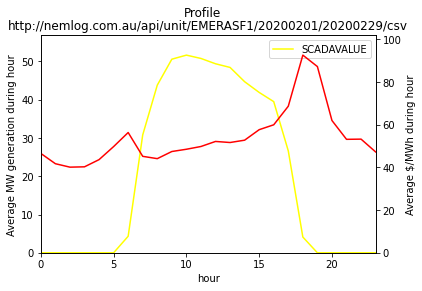

In [0]:
# create a new column 'hour' and then group by it for the whole month's data
df['hour'] = df.index.hour
df_by_hour = df.groupby(['hour'])[['RRP', 'SCADAVALUE']].mean()
plot_by_hour(df_by_hour, url)

In [0]:
# Demo 2: Use Object oriented programming to model driving a car and deciding when to fill up with fuel
#     Create a class Car to model the behaviour of the car
#         Initialising instance of Car will require litre_capacity (60L), litre_per_100_km (8 L/100km), price_break ($1.4/L)
#         Car will need instance variables to track fuel stored (litre_level) and cost of buying fuel (aud_cost).
#         Car will need a method which decides how much fuel to buy given the current price and how far travelled since last decision (litre_decision(price, km))
#         Method litre_decision(price, km) will check that fuel level does not reduce below 0 otherwise need fuel delivered to car at $50 per 10L
#         Calling litre_decision(price, km) will update litre_level and aud_cost and return the volume (litre) bought
#     Write a Python function to calculate fuel cost given the decision break price
#         Create an instance of type Car
#         Loop through dataframe (using idx as loop variable)
#             get litre bought by car
#             Store fuel bought in df.at[idx, 'litre'], fuel level before purchase in df.at[idx, 'litre level'], level in df.at[idx, 'mwh_level']
#         Print final cost of fuel
#         Plot results using provided function plot_car(df)
class Car:
  """
  A Car object represents a car/driver combination. For the car it knows the 
  size of fuel tank, fuel efficiency, and how much fuel is currently in the tank.
  For the driver it knows how the driver makes decisions on when to fill up and
  how much the driver has spent on fuel since object was created.
  """
  def __init__(self, litre_capacity=60, price_break=1.45, litre_per_100_km=7):
    self.litre_capacity = litre_capacity
    self.price_break = price_break
    self.litre_per_100_km = litre_per_100_km
    self.litre_level = litre_capacity  # start with full tank
    self.aud_cost = 0

  def litre_decision(self, price, km):
    """
    The car has driven for km kilometres and sees petrol costing price.
    This method first checks if ran out of fuel earlier in which case it records
    that some was delivered, and its cost. 
    Then this method makes the decision of whether to fill up here and records
    how much purchased it and its cost.
    This method then returns the total quantity of fuel purchased since the last
    time this method was called.
    """
    self.litre_level -= km * self.litre_per_100_km / 100
    litre_delivered = 0
    while self.litre_level < 0:
      litre_delivered += 10
      self.litre_level += 10
      self.aud_cost += 50  # Cost $50 per 10L if run out and need to have it delivered
    if price <= self.price_break:
      litre_self_serve = self.litre_capacity - self.litre_level
      self.litre_level = self.litre_capacity
      self.aud_cost += litre_self_serve * price
    else:
      litre_self_serve = 0
    return litre_self_serve + litre_delivered

In [0]:
df;

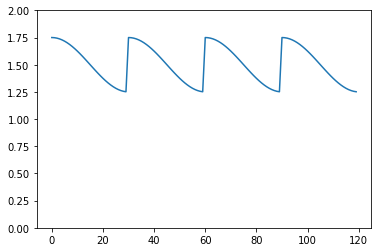

In [0]:
plot_price_for_day()

In [0]:
# Create dataframe
# first create a list of 100 petrol stations and the distance between them
lst_km_to_fuel = [random.randrange(20, 200) for i in range(100)]
# Create a dataframe with that list of data in a column called 'km to fuel'
df_demo_car = pd.DataFrame({'km to fuel': lst_km_to_fuel})
# Do a cumulative sum of this column to determine how far car has travelled when it gets to that petrol station
df_demo_car['km travelled'] = df_demo_car['km to fuel'].cumsum()
# assume we travel 40km per day so we can calculate the price based on how far we have travelled
df_demo_car['price'] = df_demo_car.apply(lambda row: price_for_day(row['km travelled'] / 40), axis='columns')
# set the dataframe to use the unique column 'km travelled' to be its index 
df_demo_car.set_index('km travelled', inplace=True)
# preview the data
df_demo_car.head(5)


,km to fuel,price
km travelled,,
26,26,1.749421
108,82,1.740073
243,135,1.701094
424,181,1.611159
577,153,1.515044


In [0]:
def cost_for_car_fuel(price_break):
  """
  Given the data of petrol stations and prices stored in dataframe df_demo_car,
  this function calculates how much it would cost for fuel for a driver who only
  buys petrol cheaper than price_break
  """
  car = Car(litre_capacity=60, price_break=price_break, litre_per_100_km=7)
  for idx in df_demo_car.index:
    df_demo_car.at[idx, 'litre'] = car.litre_decision(price=df_demo_car.at[idx, 'price'], km=df_demo_car.at[idx, 'km to fuel'])
    df_demo_car.at[idx, 'litre level'] = car.litre_level - df_demo_car.at[idx, 'litre']  # level before filling
  print(f"Using price break point ${price_break:7.4f} the total cost to fill car is ${car.aud_cost:5,.2f}")
  return car.aud_cost

Using price break point $ 1.4000 the total cost to fill car is $1,148.76
              km to fuel     price  litre  litre level
km travelled                                          
26                    26  1.749421   0.00        58.18
108                   82  1.740073   0.00        52.44
243                  135  1.701094   0.00        42.99
424                  181  1.611159   0.00        30.32
577                  153  1.515044   0.00        19.61
...                  ...       ...    ...          ...
10635                102  1.272964   7.14        52.86
10809                174  1.749931   0.00        47.82
10859                 50  1.747024   0.00        44.32
10923                 64  1.737150   0.00        39.84
11113                190  1.670659   0.00        26.54

[100 rows x 4 columns]


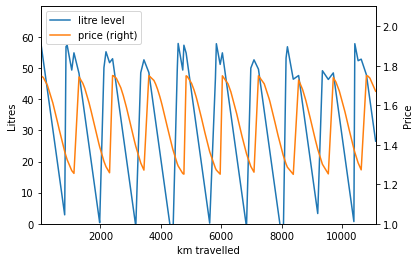

In [0]:
# Find cost if purchase fuel when 1.40 or cheaper
cost_for_car_fuel(1.4)
print(df_demo_car)
plot_car(df_demo_car)

In [0]:
# Challenge 2: We want to install a Tesla battery like the one installed in South Australia to smooth the electricity
# output from renewable energy sources. Storage capacity 129 MWh, power limit from or to grid is 100 MW.
# Assume 90% efficiency (100 MW to battery for one hour increases storage level by 90 MWh. 100 MW from battery for one hour reduces storage level by 100 MWh)
# Battery to discharge at power limit when sell price > $ 60 /MWh of stored energy
# Battery to charge at power limit when buy price < $ 60 /MWh of stored energy
# Steps:
#     Create a class Battery to model the behaviour of the battery
#         Initialising instance of Battery will require mwh_capacity (129 MWh), mw_limit (100 MW), efficiency(0.9), rrp_break ($60/MWh)
#         Battery will need instance variables to track energy stored (mwh_level) and value of buy/sell transactions (aud_profit).
#         Battery will need a method which decides how much power to buy or sell for 5 minutes given the current price (mw_decision(rrp))
#         Method mw_decision(rrp) will check that battery level does not reduce below 0 or exceed mwh_capacity
#         Calling mw_decision(rrp) will update mwh_level and aud_profit and return the power (MW) bought (+ve) or sold (-ve)
#     Write a Python script to run model for all data in dataframe
#         Create an instance of type Battery
#         Loop through dataframe (using idx as loop variable)
#             get MW bought or sold by battery
#             Store buy price in df.at[idx, 'buy'], sell price in df.at[idx, 'sell'], level in df.at[idx, 'mwh_level']
#         Print final profit of battery
#         Plot results using provided function plot_battery(df)

In [0]:
class Battery:
  """
  A Battery object represents a battery/operator combination. For the battery it
  knows the size of battery storage in MWh, the efficiency of storing energy, 
  the maximum charge/discharge rate in MW, and how much energy is currently in 
  the battery.
  For the operator it knows how the operator makes decisions on when to charge
  the battery (buy electricity), when to discharge (sell electricity), and how 
  much profit the operator has made from buying and selling.
  """
  def __init__(self, mwh_capacity, mw_limit, efficiency=0.9, rrp_break=60):
    self.mwh_capacity = mwh_capacity
    self.mw_limit = mw_limit
    self.efficiency = efficiency
    self.rrp_break = rrp_break
    self.mwh_level = 0
    self.aud_profit = 0

  def mw_decision(self, rrp):
    """
    This method implements the logic of should the operator buy or sell 
    electricity based on price per stored MWh. If the RRP (regional reference 
    price) we can get per stored MWh is greater than the break price, we sell 
    and if it is less we buy. Expense and income from buying and selling is 
    accumulated in aud_profit. 
    Method returns the current rate of buying (+ve) or selling (-ve) in MW.
    Notes:
    We can't sell more than is stored in the battery
    We can't buy more than will fit in the battery
    We can't buy or sell faster than our limit in MW
    When we buy 1.0 MWh we only store 0.9 MWh because of battery efficiency.
    If we buy 1.0 MWh at $63/MWh we store 0.9 MWh at $63/0.9MWh = $70/MWh 
    (Changing battery efficiency will change this.)
    Buy sell decisions are made every 5 minutes. Selling 72 MW for 5 minutes is
    the same as selling 6MWh (72 MW * (5/60) h) = 6 MWh
    """
    if rrp >= self.rrp_break:
      mw = -min(self.mwh_level * 12, self.mw_limit)
      self.mwh_level += mw / 12
    elif rrp <= self.rrp_break * self.efficiency:
      mw = min((self.mwh_capacity - self.mwh_level) * 12 / self.efficiency, self.mw_limit)
      self.mwh_level += mw / 12 * self.efficiency
    else:
      mw = 0
    self.aud_profit -= mw * rrp / 12
    return mw

In [0]:
# test the class by creating an instance
b = Battery(mwh_capacity=129, mw_limit=100, efficiency=0.9, rrp_break=70)

In [0]:
b.mwh_level, b.aud_profit

(0, 0)

In [0]:
rrp = 50
print(f"RRP ${rrp:5.2f} Decision {b.mw_decision(rrp):7.1f} MW, level {b.mwh_level:7.1f} MWh, profit ${b.aud_profit:10,.2f}")
print(f"RRP ${rrp:5.2f} Decision {b.mw_decision(rrp):7.1f} MW, level {b.mwh_level:7.1f} MWh, profit ${b.aud_profit:10,.2f}")
print(f"RRP ${rrp:5.2f} Decision {b.mw_decision(rrp):7.1f} MW, level {b.mwh_level:7.1f} MWh, profit ${b.aud_profit:10,.2f}")
rrp = 90
print(f"RRP ${rrp:5.2f} Decision {b.mw_decision(rrp):7.1f} MW, level {b.mwh_level:7.1f} MWh, profit ${b.aud_profit:10,.2f}")

RRP $50.00 Decision   100.0 MW, level     7.5 MWh, profit $   -416.67
RRP $50.00 Decision   100.0 MW, level    15.0 MWh, profit $   -833.33
RRP $50.00 Decision   100.0 MW, level    22.5 MWh, profit $ -1,250.00
RRP $90.00 Decision  -100.0 MW, level    14.2 MWh, profit $   -500.00


In [0]:
# Test battery for month using a price break of $65/MWh
rrp_break = 65
battery = Battery(mwh_capacity=129, mw_limit=100, rrp_break=rrp_break)
for idx in df.index:
    mw_buy_or_sell = battery.mw_decision(df.at[idx, 'RRP'])
    if mw_buy_or_sell < 0:
        df.at[idx, 'buy'], df.at[idx, 'sell'] = None, df.at[idx, 'RRP']
    elif mw_buy_or_sell > 0:
        df.at[idx, 'buy'], df.at[idx, 'sell'] = df.at[idx, 'RRP'], None
    else:
        df.at[idx, 'buy'], df.at[idx, 'sell'] = None, None
    df.at[idx, 'aud_profit'] = -mw_buy_or_sell * df.at[idx, 'RRP'] / 12
    df.at[idx, 'mwh_level'] = battery.mwh_level
print(f"RRP break point ${rrp_break:5,.2f}. Profit ${battery.aud_profit:10,.2f}  ")
pd.set_option('display.max_columns', 20)
print(df.head())

RRP break point $65.00. Profit $535,625.51  
                         DUID      RRP REGIONID  SCADAVALUE      buy  sell  \
SETTLEMENTDATE                                                               
2020-01-01 00:05:00  EMERASF1  50.8115     QLD1         0.0  50.8115   NaN   
2020-01-01 00:10:00  EMERASF1  51.1437     QLD1         0.0  51.1437   NaN   
2020-01-01 00:15:00  EMERASF1  51.4835     QLD1         0.0  51.4835   NaN   
2020-01-01 00:20:00  EMERASF1  51.8115     QLD1         0.0  51.8115   NaN   
2020-01-01 00:25:00  EMERASF1  50.8972     QLD1         0.0  50.8972   NaN   

                     aud_profit  mwh_level  
SETTLEMENTDATE                              
2020-01-01 00:05:00 -423.429167        7.5  
2020-01-01 00:10:00 -426.197500       15.0  
2020-01-01 00:15:00 -429.029167       22.5  
2020-01-01 00:20:00 -431.762500       30.0  
2020-01-01 00:25:00 -424.143333       37.5  


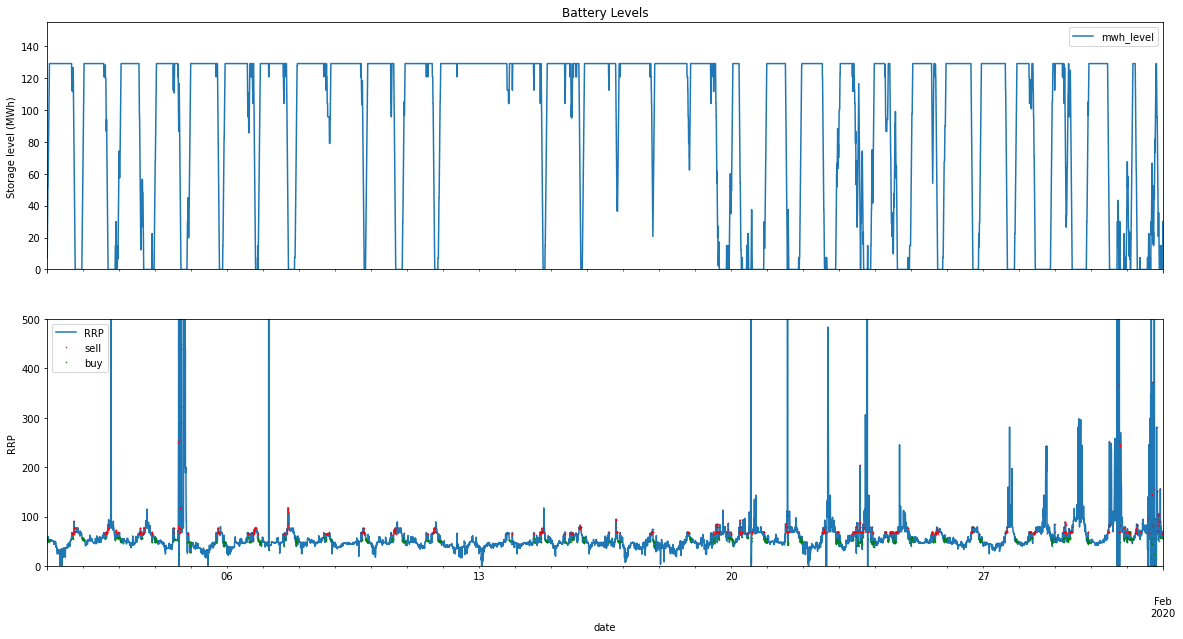

In [0]:
plot_battery(df)

Using price break point $ 1.6000 the total cost to fill car is $1,078.30
Using price break point $ 1.6800 the total cost to fill car is $1,159.77
Using price break point $ 1.5200 the total cost to fill car is $1,048.88
Using price break point $ 1.4400 the total cost to fill car is $1,117.71
Using price break point $ 1.4400 the total cost to fill car is $1,117.71
Using price break point $ 1.5600 the total cost to fill car is $1,068.41
Using price break point $ 1.4800 the total cost to fill car is $1,071.04
Using price break point $ 1.5400 the total cost to fill car is $1,061.64
Using price break point $ 1.5000 the total cost to fill car is $1,040.83
Using price break point $ 1.4800 the total cost to fill car is $1,071.04
Using price break point $ 1.4800 the total cost to fill car is $1,071.04
Using price break point $ 1.5100 the total cost to fill car is $1,040.83
Using price break point $ 1.4900 the total cost to fill car is $1,040.83
Using price break point $ 1.5050 the total cost to 

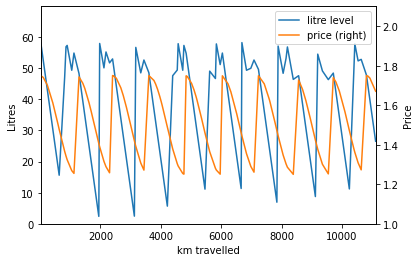

In [0]:
# Demo 3: Find the optimum price break point using scipy.optimize.minimize(fun, x0, method, options)
#     fun is loss or objective function to be minimised. Loss is negative of profit (which we want to maximise)
#     x0 is initial guess array. Can be numpy ndarray or python list
#     method is optimization method. Try 'Nelder-Mead'
#     options is dict of options eg {'disp': True, 'xatol': 0.1, 'fatol': 10}
#         disp: set to True to print convergence messages
#         xatol: Absolute error in xopt between iterations that is acceptable for convergence
#         fatol: Absolute error in func(xopt) between iterations that is acceptable for convergence.
# Method Nelder-Mead uses the Simplex algorithm. This algorithm is robust in many applications. However, if
# numerical computation of derivative can be trusted, other algorithms using the first and/or second derivatives
# information might be preferred for their better performance in general.
def loss_for_price_break(x):
    return cost_for_car_fuel(price_break=x[0])


result = minimize(loss_for_price_break, x0=np.array([1.6]), method='Nelder-Mead', options={'disp': True, 'xatol': 0.01, 'fatol': 1})
print(f"Optimisation result for car purchasing fuel {result}")
plot_car(df_demo_car)

In [0]:
# Challenge 3: Find the optimum rrp break point using scipy.optimize.minimize(fun, x0, method, options)

In [0]:
def loss_function_for_rrp_break(x):
  rrp_break = x[0]
  battery = Battery(mwh_capacity=129, mw_limit=100, rrp_break=rrp_break)
  for idx in df.index:
    mw_buy_or_sell = battery.mw_decision(df.at[idx, 'RRP'])
    if mw_buy_or_sell < 0:
      df.at[idx, 'buy'], df.at[idx, 'sell'] = None, df.at[idx, 'RRP']
    elif mw_buy_or_sell > 0:
      df.at[idx, 'buy'], df.at[idx, 'sell'] = df.at[idx, 'RRP'], None
    else:
      df.at[idx, 'buy'], df.at[idx, 'sell'] = None, None
    df.at[idx, 'aud_profit'] = -mw_buy_or_sell * df.at[idx, 'RRP'] / 12
    df.at[idx, 'mwh_level'] = battery.mwh_level
  aud_profit_excl_storage = battery.aud_profit
  aud_profit_incl_storage = battery.aud_profit + battery.mwh_level * battery.rrp_break
  print(f"RRP break point ${rrp_break:5,.2f}. Profit excl storage ${battery.aud_profit:10,.2f}. Profit incl storage ${aud_profit_incl_storage:10,.2f}")
  return -aud_profit_incl_storage


RRP break point $50.00. Profit excl storage $383,378.60. Profit incl storage $383,378.60
RRP break point $52.50. Profit excl storage $392,689.86. Profit incl storage $392,689.86
RRP break point $55.00. Profit excl storage $510,141.82. Profit incl storage $510,141.82
RRP break point $57.50. Profit excl storage $520,248.23. Profit incl storage $520,248.23
RRP break point $62.50. Profit excl storage $538,734.36. Profit incl storage $539,151.03
RRP break point $67.50. Profit excl storage $530,909.12. Profit incl storage $533,384.12
RRP break point $67.50. Profit excl storage $530,909.12. Profit incl storage $533,384.12
RRP break point $65.00. Profit excl storage $535,625.51. Profit incl storage $537,033.85
RRP break point $60.00. Profit excl storage $530,740.50. Profit incl storage $530,740.50
RRP break point $63.75. Profit excl storage $537,202.89. Profit incl storage $538,584.14
RRP break point $61.25. Profit excl storage $534,933.01. Profit incl storage $534,933.01
RRP break point $63.1

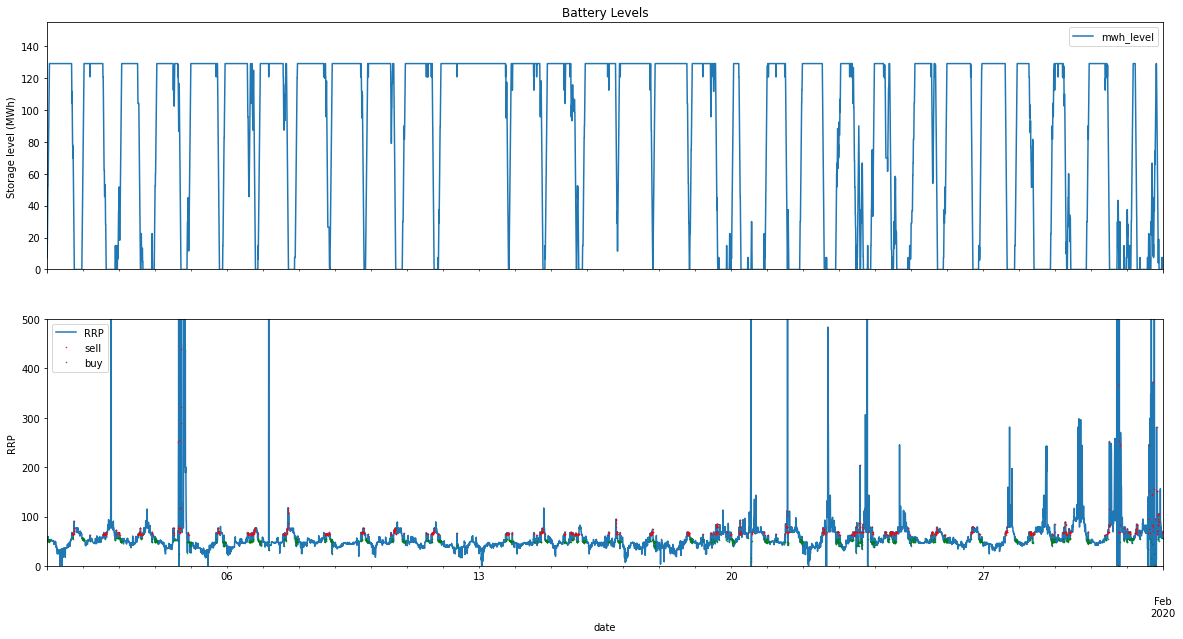

In [0]:
result = minimize(loss_function_for_rrp_break, x0=np.array([50]), method='Nelder-Mead', options={'disp': True, 'xatol': 0.1, 'fatol': 10})
print(f"Optimisation result {result}")
plot_battery(df_for_plot=df)

In [0]:
def loss_function_for_rrp_break(x):
  rrp_break = x[0]
  battery = Battery(mwh_capacity=129, mw_limit=100, rrp_break=rrp_break)
  for idx in df.index:
    mw_buy_or_sell = battery.mw_decision(df.at[idx, 'RRP'])
    if mw_buy_or_sell < 0:
      df.at[idx, 'buy'], df.at[idx, 'sell'] = None, df.at[idx, 'RRP']
    elif mw_buy_or_sell > 0:
      df.at[idx, 'buy'], df.at[idx, 'sell'] = df.at[idx, 'RRP'], None
    else:
      df.at[idx, 'buy'], df.at[idx, 'sell'] = None, None
    df.at[idx, 'aud_profit'] = -mw_buy_or_sell * df.at[idx, 'RRP'] / 12
    df.at[idx, 'mwh_level'] = battery.mwh_level
  aud_profit_excl_storage = battery.aud_profit
  aud_profit_incl_storage = battery.aud_profit + battery.mwh_level * battery.rrp_break
  print(f"RRP break point ${rrp_break:5,.2f}. Profit excl storage ${battery.aud_profit:10,.2f}. Profit incl storage ${aud_profit_incl_storage:10,.2f}")
  return -aud_profit_incl_storage


result = minimize(loss_function_for_rrp_break, x0=np.array([50]), method='Nelder-Mead', options={'disp': True, 'xatol': 0.1, 'fatol': 10})
print(f"Optimisation result {result}")
plot_battery(df_for_plot=df)

In [0]:
# Challenge 4: Modify mw_decision(rrp) so that if rrp is only just higher 
# only a little bit of electricity is sold but if rrp is a lot higher then
# it is sold at maximum rate.
# Optimise how much to sell based on how much above rrp

In [0]:
class Battery:
  def __init__(self, mwh_capacity, mw_limit, efficiency=0.9, rrp_break=62.45, rrp_factor=1):
    self.mwh_capacity = mwh_capacity
    self.rrp_break = rrp_break
    self.rrp_factor = rrp_factor  # Challenge 4
    self.mw_limit = mw_limit
    self.mwh_level = 0
    self.aud_profit = 0
    self.efficiency = efficiency

  def mw_decision(self, rrp):
    if rrp >= self.rrp_break:
      # mw = -min(self.mwh_level * 12, self.mw_limit)
      mw = -min(self.mw_limit, self.mwh_level * 12, (rrp - self.rrp_break) / self.rrp_break * self.rrp_factor)  # -ve means sell  # Challenge 4
      self.mwh_level += mw / 12
    elif rrp <= self.rrp_break * self.efficiency:
      # mw = min((self.mwh_capacity - self.mwh_level) * 12 / self.efficiency, self.mw_limit)
      mw = min(self.mw_limit, (self.mwh_capacity - self.mwh_level) * 12 / self.efficiency, -(rrp - self.rrp_break * self.efficiency) / self.rrp_break * self.rrp_factor)  # +ve means buy  # Challenge 4
      self.mwh_level += mw / 12 * self.efficiency
    else:
      mw = 0
    self.aud_profit -= mw * rrp / 12
    return mw

In [0]:
def loss_function_for_rrp_break_and_factor(x):
  rrp_break = x[0]
  # Challenge 4
  rrp_factor = x[1]
  # Tesla battery for South Australia. Cost ~ AUD 90 million + maintenance AUD 5 million per year, capacity 129 MWh, throughput 100 MW
  # Challenge 4  
  battery = Battery(mwh_capacity=129, mw_limit=100, rrp_break=rrp_break, rrp_factor=rrp_factor)
  for idx in df.index:
    mw_buy_or_sell = battery.mw_decision(df.at[idx, 'RRP'])
    if mw_buy_or_sell < 0:
      df.at[idx, 'buy'], df.at[idx, 'sell'] = None, df.at[idx, 'RRP']
    elif mw_buy_or_sell > 0:
      df.at[idx, 'buy'], df.at[idx, 'sell'] = df.at[idx, 'RRP'], None
    else:
      df.at[idx, 'buy'], df.at[idx, 'sell'] = None, None
    df.at[idx, 'aud_profit'] = -mw_buy_or_sell * df.at[idx, 'RRP'] / 12
    df.at[idx, 'mwh_level'] = battery.mwh_level
  aud_profit_excl_storage = battery.aud_profit
  aud_profit_incl_storage = battery.aud_profit + battery.mwh_level * battery.rrp_break
  print(f"RRP break point ${rrp_break:7,.2f}, factor {rrp_factor:7.4f} MW. Profit excl storage ${battery.aud_profit:10,.2f}. Profit incl storage ${aud_profit_incl_storage:10,.2f}")
  return -aud_profit_incl_storage

RRP break point $  62.00, factor 50.0000 MW. Profit excl storage $566,099.59. Profit incl storage $567,416.03
RRP break point $  65.10, factor 50.0000 MW. Profit excl storage $682,470.17. Profit incl storage $684,821.80
RRP break point $  62.00, factor 52.5000 MW. Profit excl storage $563,786.61. Profit incl storage $565,016.45
RRP break point $  65.10, factor 47.5000 MW. Profit excl storage $680,567.56. Profit incl storage $682,893.11
RRP break point $  68.20, factor 47.5000 MW. Profit excl storage $681,763.38. Profit incl storage $685,003.34
RRP break point $  71.30, factor 46.2500 MW. Profit excl storage $680,508.17. Profit incl storage $684,630.60
RRP break point $  68.20, factor 50.0000 MW. Profit excl storage $684,025.58. Profit incl storage $687,340.34
RRP break point $  69.75, factor 51.2500 MW. Profit excl storage $684,730.93. Profit incl storage $688,590.50
RRP break point $  72.85, factor 48.7500 MW. Profit excl storage $686,134.60. Profit incl storage $690,839.55
RRP break 

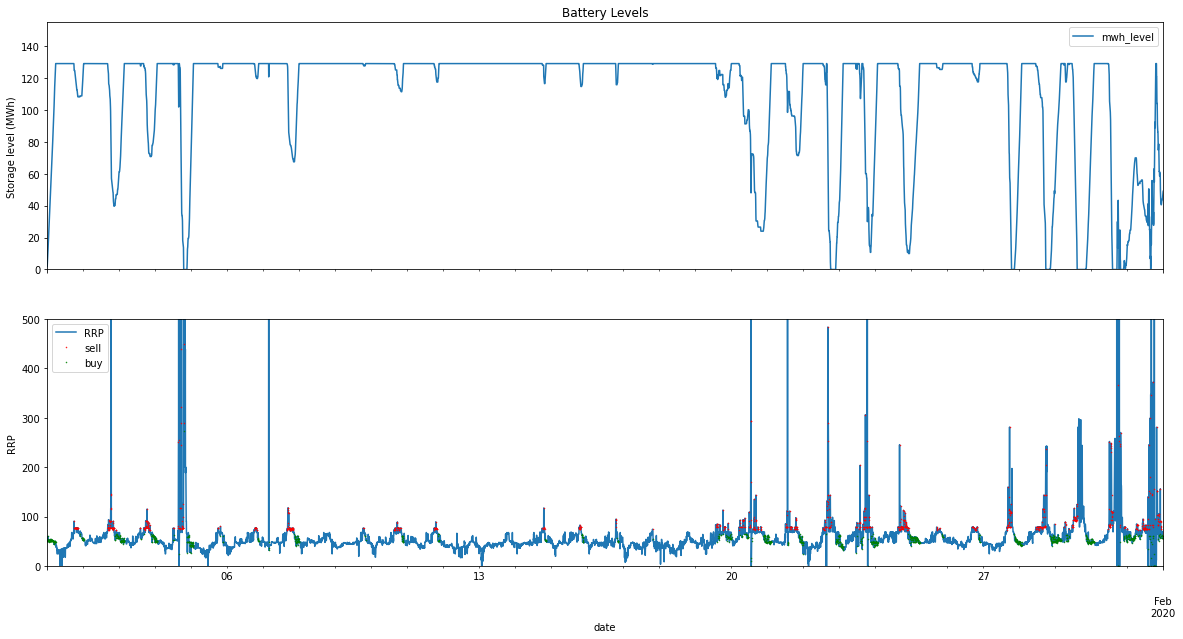

In [0]:
result = minimize(loss_function_for_rrp_break_and_factor, x0=np.array([62, 50]), method='Nelder-Mead', options={'disp': True, 'xatol': 0.1, 'fatol': 10})
print(f"Optimisation result {result}")
plot_battery(df_for_plot=df)

In [0]:
# Compare different starting values [62, 50], [62, 10]
# [62, 10] RRP break point $  90.25, factor  27.1534 MW. Profit excl storage $814,044.18. Profit incl storage $825,686.35
# [62, 50] RRP break point $  71.89, factor 130.6953 MW. Profit excl storage $750,490.21. Profit incl storage $754,013.75